## **Image Warping**
This notebook will be used to explore the concept of image warping and thereby generate the dataset for MVDiffussion

In [2]:
import numpy as np
import os
import pandas as pd
import cv2
import scipy as sp
import matplotlib.pyplot as plt
import itertools
import random
import reconstruction_deep_network

In [13]:
module_dir = reconstruction_deep_network.__path__[0]
root_dir = os.path.dirname(module_dir)
scans_dir = "data/v1/scans/17DRP5sb8fy"
skybox_img_dir = os.path.join(root_dir, scans_dir, "matterport_skybox_images")

In [7]:
vx = [-90, 270, 0, 90, 180, -90]
vy = [90, 0, 0, 0, 0, -90]
fov = 90
rot = 45
resolution = 512
crop_size = 512

In [16]:
def load_skybox_image(img_name: str, index: int):
    img_name = f"{img_name}_skybox{index}_sami.jpg"
    img_path = os.path.join(skybox_img_dir, img_name)
    img = cv2.imread(img_path)
    return img

def load_skybox_images(img_name):
    skybox_indices = list(range(6))
    images = []
    for idx in skybox_indices:
        img = load_skybox_image(img_name, idx)
        images.append(img)
    
    return images

def get_K_R(FOV, THETA, PHI, height, width):
    f = 0.5 * width * 1 / np.tan(0.5 * FOV / 180.0 * np.pi)
    cx = (width - 1) / 2.0
    cy = (height - 1) / 2.0
    K = np.array([
        [f, 0, cx],
        [0, f, cy],
        [0, 0,  1],
    ], np.float32)

    y_axis = np.array([0.0, 1.0, 0.0], np.float32)
    x_axis = np.array([1.0, 0.0, 0.0], np.float32)
    R1, _ = cv2.Rodrigues(y_axis * np.radians(THETA))
    R2, _ = cv2.Rodrigues(np.dot(R1, x_axis) * np.radians(PHI))
    R = R2 @ R1
    return K, R

def warp_img(fov, theta, phi, images, vx, vy):
    img_combine = np.zeros(images[0].shape).astype(np.uint8)

    min_theta = 10000
    for i, img in enumerate(images):
        _theta = vx[i]-theta
        _phi = vy[i]-phi

        if i == 2 and theta > 270:
            _theta = max(360-theta, _theta)
        if _phi == 0 and np.absolute(_theta) > 90:
            continue

        if i > 0 and i < 5 and np.absolute(_theta) < min_theta:
            min_theta = _theta
            min_idx = i

        im_h, im_w, _ = img.shape
        K, R = get_K_R(fov, _theta, _phi, im_h, im_w)
        homo_matrix = K@R@np.linalg.inv(K)
        img_warp1 = cv2.warpPerspective(img, homo_matrix, (im_w, im_h))
        if i == 0:
            img_warp1[im_h//2:] = 0
        elif i == 5:
            img_warp1[:im_h//2] = 0

        img_combine += img_warp1  # *255).astype(np.uint8)
    return img_combine

In [34]:
imgs = []
num_views = 8
init_degree = 90
images_raw = load_skybox_images("00ebbf3782c64d74aaf7dd39cd561175")

for i in range(num_views):
    _degree = (init_degree+rot*i) % 360
    img = warp_img(
                90, _degree, 0, images_raw, vx, vy)
    img = cv2.resize(img, (resolution, resolution))

    imgs.append(img)

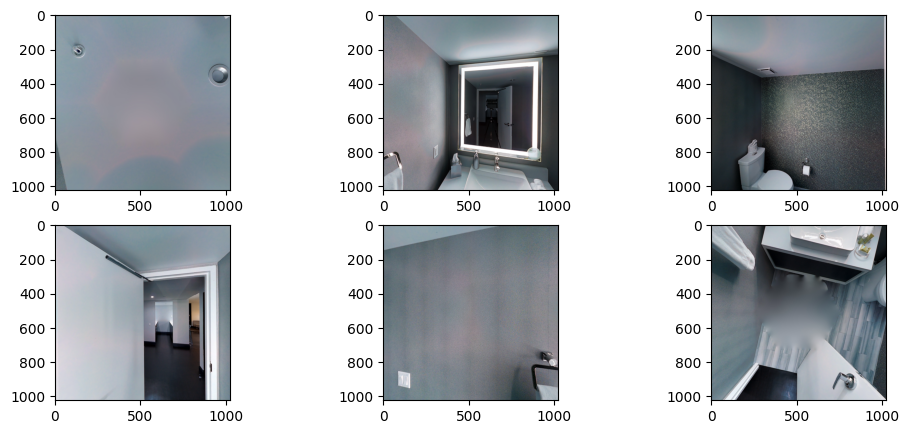

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(12, 5))
combs = list(itertools.product(list(range(2)), list(range(3))))

for itr, comb in enumerate(combs):
    axs[comb].imshow(images_raw[itr])

plt.show()

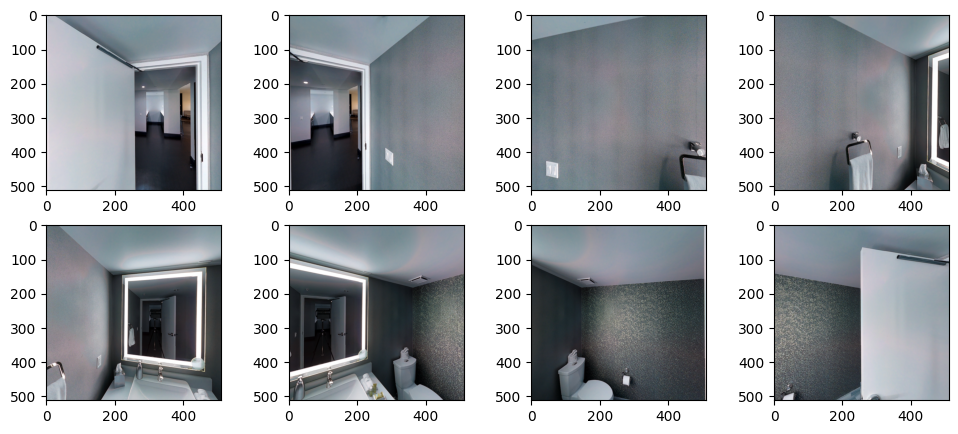

In [36]:
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
combs = list(itertools.product(list(range(2)), list(range(4))))

for itr, comb in enumerate(combs):
    axs[comb].imshow(imgs[itr])

plt.show()
